# Assignment 2: Classification
# Using Machine Learning Tools CS3317

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are: 

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code, some require graphical results. 

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code runs correctly on the original data file.

Some of the parts of this assignment build on the workflow from the first assignment and that part of the course, and so less detailed instructions are provided for this, as you should be able to implement this workflow now without low-level guidance. A substantial portion of the marks for this assignment are associated with making the right choices and executing this workflow correctly and efficiently.

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. **Other libraries should not be used** (even though they might have nice functionality) and certain restrictions on sklearn functions will be made clear in the instruction text. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

# Scenario

A client approaches you to solve a machine learning problem for them. They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. The dataset contains measurements of several features that describe characteristics of cell nuclei present in digital images of breast tissue samples. These features include the mean, standard error, and "worst" (i.e., largest) values of measurements such as radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, and fractal dimension. Each feature is represented by a numeric value, and each data point represents a sample from either a malignant (cancerous) or benign (non-cancerous) breast tissue.

The client want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail, as appropriate to the marks given.

In [42]:
# This code imports some libraries that you will need. 
# You should not need to modify it, though you are expected to make other imports later in your code.

# Common imports
import sys
import numpy as np
import time
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import re

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

**Step 1** [1 point]

Load the dataset Do this from the csv file, `assignment2.csv`. Extract the feature names for use later on. The first column is our target and it contains the labels (benign and malignant). Note that we will be treating the _malignant_ case as our _positive_ case, as this is the standard convention in medicine.

In [43]:
data = pd.read_csv('assignment2.csv')

feature_names = data.columns[1:].tolist()

# The following code is used by the autograder
# make sure your variable that contains the answer from this step is the one assigned to step1_1data
step1_data = data.copy()

<!-- BEGIN QUESTION -->

**Step 2** [3 points]

As this data is well curated by the client already, you do not need to worry about outliers, missing values or imputation in this case, but be aware that this is the exception, not the rule.

To familiarise yourself with the nature and information contained in the data, display histograms for the data according to the following instructions:
 - Isolate each group of features (mean, standard error, and worst) into its own DataFrame.
 - you are provided with code to display histograms for each feature in the _mean_ group. On _each_ histogram the two classes displayed together in one plot 
 - **repeat this** for the _standard error_ and _worst_ groups; 

**Based on the histograms and using the function *corr()* or *numpy corrcoef()* which do you think are the 3 strongest features for discriminating between the classes?**

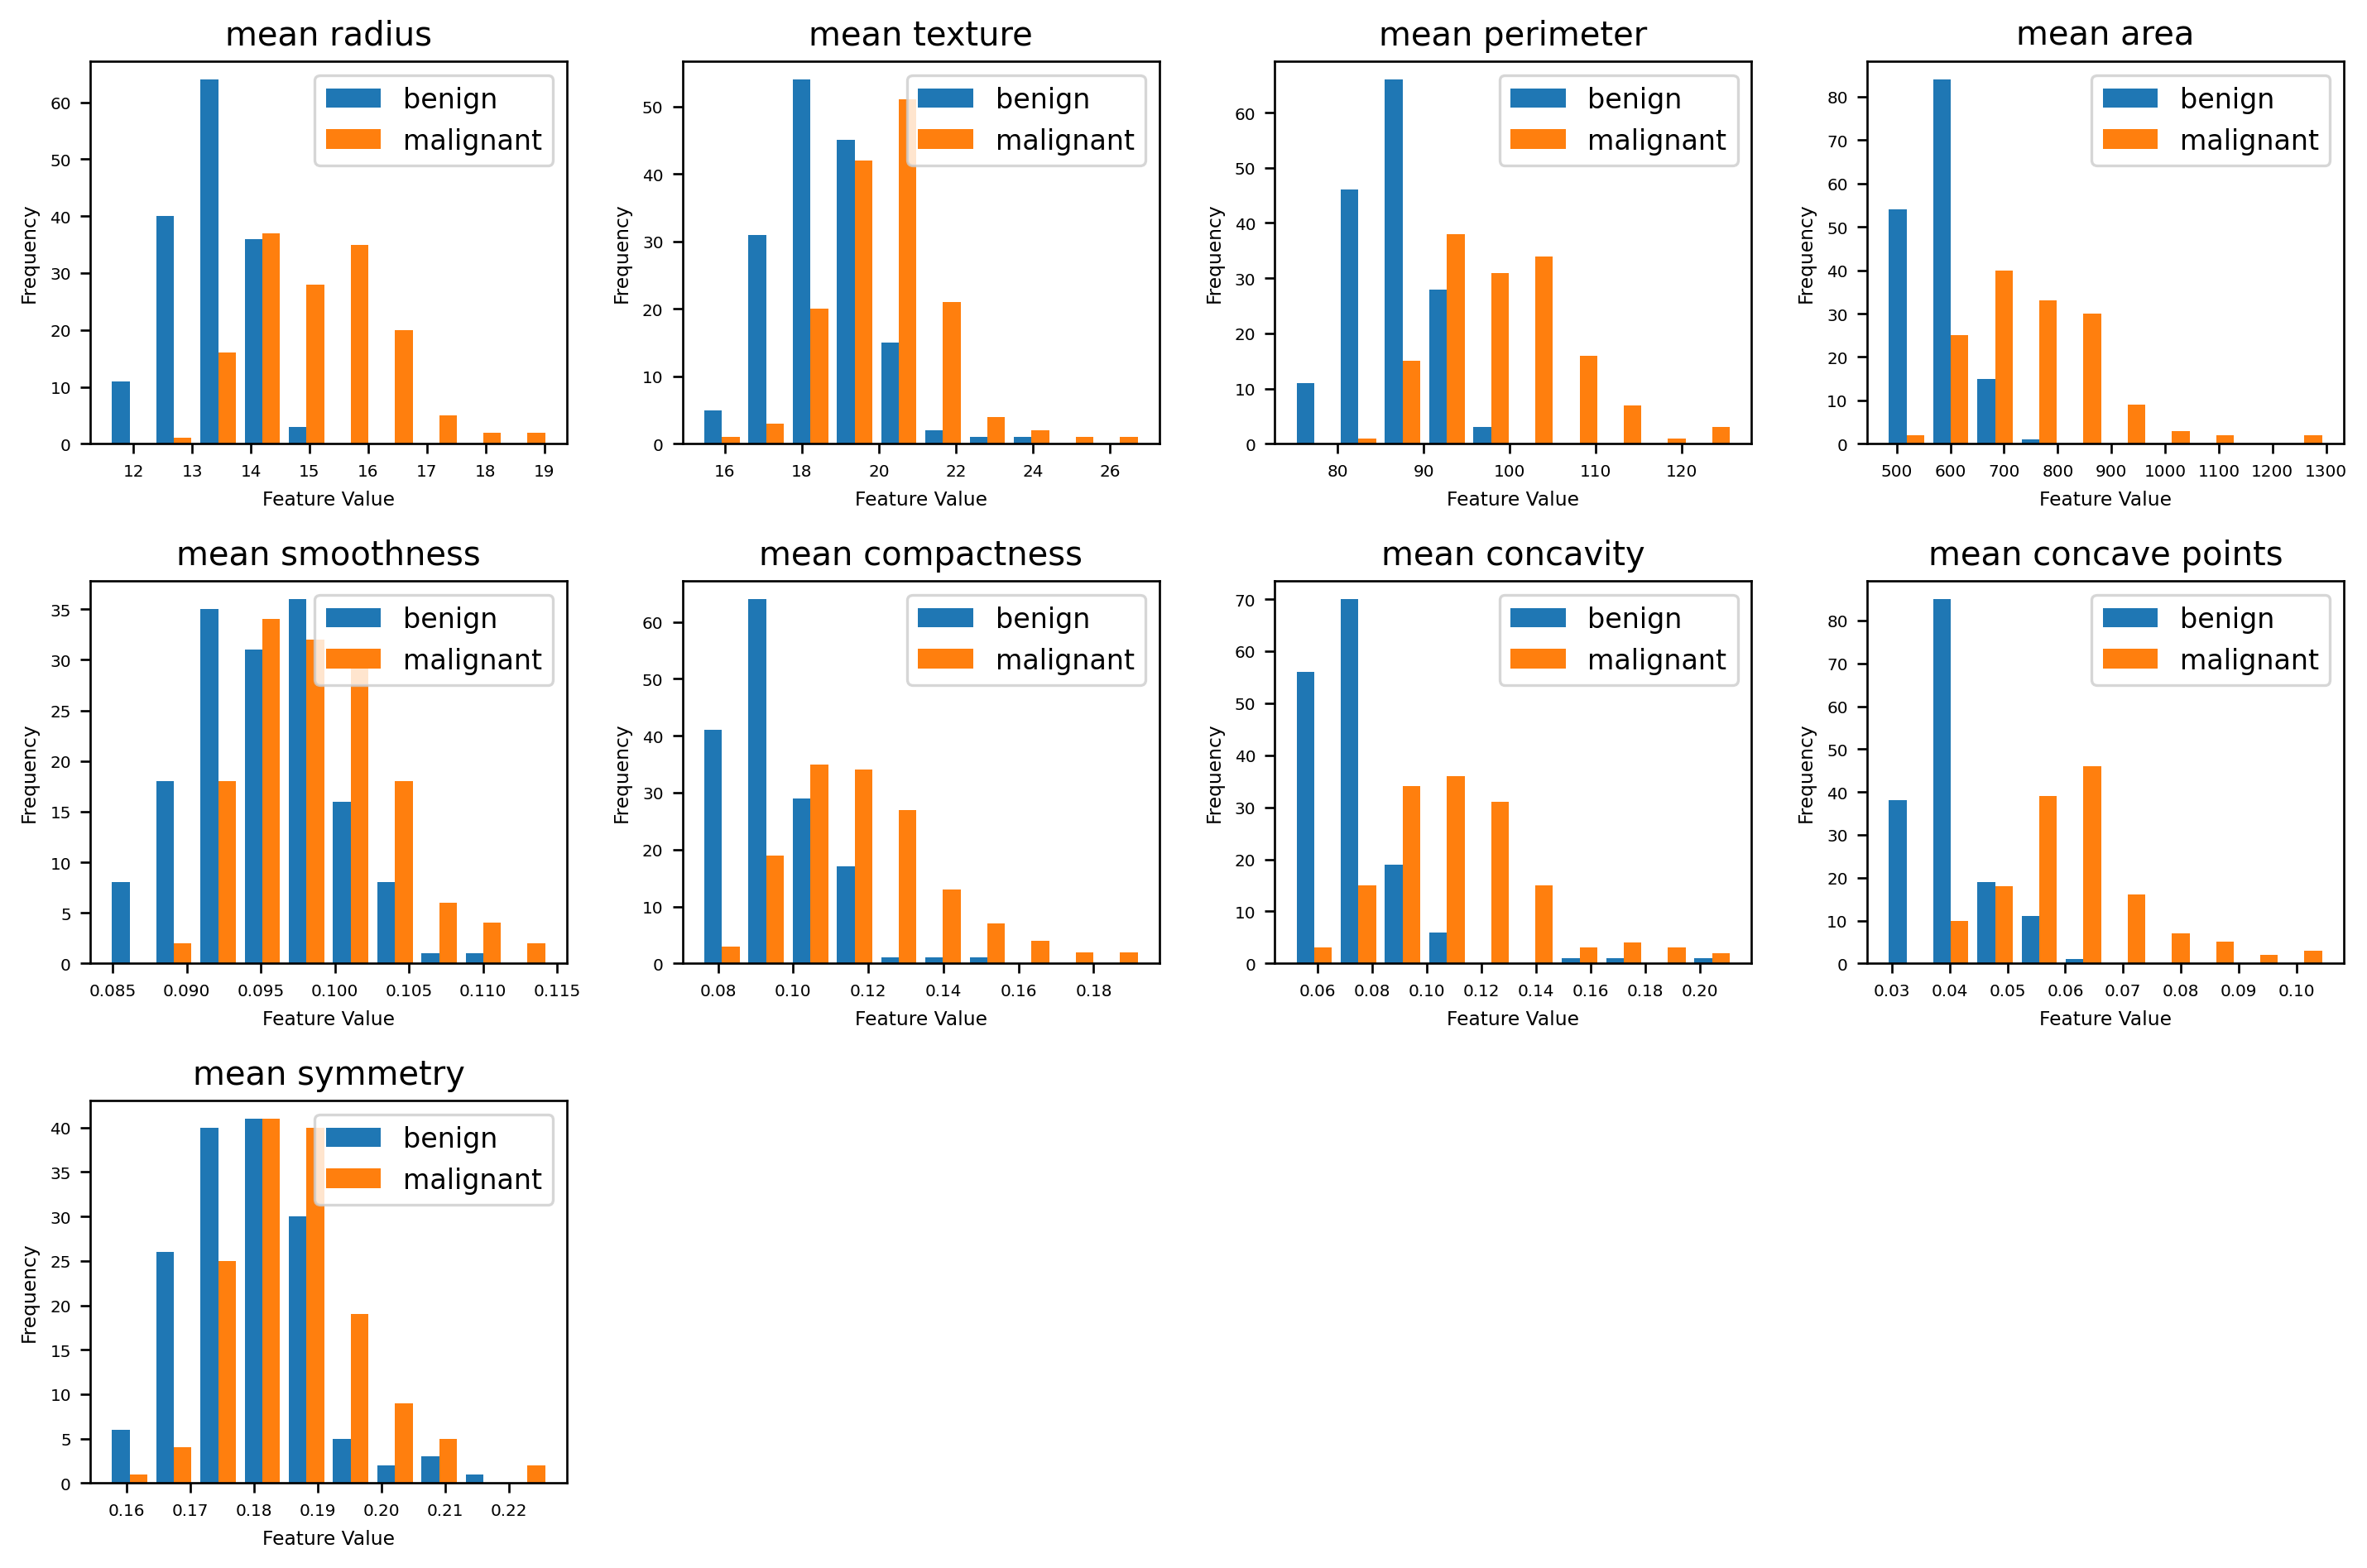

In [44]:
# Separate the mean, standard error, and worst groups into separate dataframes

# xarray = data.data
# yarray = data.target
# fullarray = np.concatenate((xarray,np.reshape(yarray,(-1,1))),axis=1)
# mean_group = pd.DataFrame(fullarray, columns = list(data.feature_names) + ['mean_group'])
# error_group = pd.DataFrame(fullarray, columns = list(data.feature_names) + ['error_group'])
# worst_group = pd.DataFrame(fullarray, columns = list(data.feature_names) + ['worst_group'])

mean_group = data.iloc[:,1:10]
error_group = data.iloc[:,11:20]
worst_group = data.iloc[:,21:30]
#  You can comment out the plotting code before uploading it to gradescope for faster evaluation
class_labels = ['benign', 'malignant'] 
fig = plt.figure(figsize=(12, 8))  

# Plot the histograms for each feature in the mean group with both classes displayed together
for i, feature in enumerate(mean_group.columns):  
    plt.subplot(3, 4, i+1)  
    plt.hist([mean_group[feature][data['label'] == 'benign'], mean_group[feature]
             [data['label'] == 'malignant']], label=class_labels)  
    plt.xlabel("Feature Value")  
    plt.ylabel("Frequency")  
    plt.legend() 
    plt.title(feature)  

plt.tight_layout()  
plt.show()  

# data['label'].replace(['malignant','benign'],[1,0],inplace=True)
# corr = data.corr()['label'].sort_values(ascending=False)
# print(corr)

# ranked_features = ["Feature1 name", "Feature2 name", "Feature3 name"] 
ranked_features = ["worst concave points", "worst perimeter", "worst radius"]

# The following code is used by the autograder
step2_data = ranked_features

<!-- END QUESTION -->

**Step3** [3 points]

Convert the labels into 0s and 1s so that benign is represented by 0 and malignant is represented by 1.

Split the dataset into appropriate subsets for training, validation and test sets. You must choose the size of each subset. However, make sure that the proportion of the two classes is consistent across all datasets using the _stratify_ option, as used in workshops 5 and 6. Verify the size and label distribution in each dataset.

In [45]:
from sklearn.model_selection import train_test_split

# Convert labels to 0 (benign) and 1 (malignant)
data['label'].replace(['malignant','benign'],[1,0],inplace=True)

# Split dataset into training, validation, and test sets
# bigtrain_set,test_set = train_test_split(data,test_size=0.2, random_state = 20)
# train_set, val_set = train_test_split(bigtrain_set, test_size=0.2, random_state=20)

# X_train = train_set.iloc[:,:-1]
# y_train = train_set.iloc[:,-1]
# X_test = test_set.iloc[:,:-1]
# y_test = test_set.iloc[:,-1]
# X_val = val_set.iloc[:,:-1]
# y_val = val_set.iloc[:,-1]

bigtrain_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.2, random_state=42, stratify=bigtrain_set['label'])

X_train = train_set.drop("label",axis=1)
y_train = train_set["label"].copy()
X_test = test_set.drop("label",axis=1)
y_test = test_set["label"].copy()
X_val = val_set.drop("label",axis=1)
y_val = val_set["label"].copy()

# Print the size of each resulting subset
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# The following code is used by the autograder
step3_data = [len(X_train) , len(X_val) , len(X_test)]

Training set size: 192
Validation set size: 48
Test set size: 60


**Step4** [4 points]

Baseline measurements 

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class 

In [46]:
from numpy.random import default_rng
# create arrays to hold the predicted labels for each baseline case
baseline1_preds = np.zeros(y_val.shape[0])
baseline2_preds = np.ones(y_val.shape[0])

rng = default_rng()
numbers = rng.choice(y_val.shape[0], size=int(y_val.shape[0] / 2), replace=False)
random_y_test = np.zeros(y_val.shape[0])
random_y_test[numbers] = 1
baseline3_preds = random_y_test

# The following code is used by the autograder.
step4_data = [baseline1_preds, baseline2_preds, baseline3_preds] 

**Step5** [2 points]

Write a function that returns the following metrics for all baseline measures created in Step4, use the function and print the metrics:

 - recall
 - precision
 - auc
 - f1score

In [47]:
condition_map = [{
    'name': 'all negative baseline',
    'y_pred': np.zeros(y_val.shape[0]),
}, {
    'name': 'all positive baseline',
    'y_pred': np.ones(y_val.shape[0]),
}, {
    'name': 'random baseline',
    'y_pred': random_y_test,
}]

def calculate_metrics(y_true, y_pred):   
    rec = recall_score(y_true, y_pred),
    prec = precision_score(y_true, y_pred),
    auc = auc(fpr = roc_curve(_y_true, _y_pred), , tpr = roc_curve(_y_true, _y_pred)),
    f1 = f1_score(_y_true, _y_pred)

    # rec = recall(y_true, y_pred)
    # prec = precision(y_true, y_pred)
    # auc = roc_auc(y_true, y_pred)
    # f1 = f1(y_true, y_pred)

    return rec, prec, auc, f1

# The following code is used by the autograder.
step5_data = calculate_metrics

**Step6** [3 points]

Create a function which takes in the true labels and the predictions and returns the following parameters:

* Number of True Positives (TP)
* Number of True Negatives (TN)
* Number of False Positive (FP)
* Number of False Negative (FN)

In [38]:
# This function returns the number of TP, TN, FP, FN.
def get_values(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    return tp, tn, fp, fn

# The following code is used by the autograder.
step6_data = get_values

**Step7 [3 points]**

Based on the above baseline tests and the client's requirements, **choose a performance metric** to use for evaluating/driving your machine learning methods.

Choose the best metric of the five and assign to the variable below.
* For AUC, use "roc_auc"
* For recall, use "recall"
* For precision, use "precision"
* For F1 Score, use "f1"

***NOTE:*** Not all the metrics are equally useful for meeting the requirements of the client, thereby, choose only the one most suitable metric.

In [48]:
# Choose the best metric of the five and assign to the variable below. The variable takes a string.
chosen_metric = "roc_auc"

# The following code is used by the autograder
step7_data = chosen_metric

**Step8** [3 points]

**Creating a SGD baseline**

For a stronger baseline, **train the Stochastic Gradient Descent classifier (SGD) model** on the training data and evaluate it on the validation data (as seen in workshop 4). Use a Pipeline for this which considers the preprocessing and the SGD model. For this baseline case use the default settings for all the hyperparameters.

Build a pre-processing pipeline that includes imputation (as even though we don't strictly need it here it is a good habit to always include it) and other appropriate pre-processing. Create another pipeline for the SGD model which has preprocessing pipeline as the pre-processing part. Train the model and evaluate it on the validation data.   

In [50]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier

# Create pre-processing pipeline
preproc_pl = Pipeline([('imputer',SimpleImputer(strategy="median")),
                       ('stdscaler',StandardScaler())])

# Create SGD model pipeline which has preproc_pl as the pre-processing part
sgd_base = Pipeline([ ('preproc',preproc_pl), ('sgd',SGDClassifier(random_state=42))])

# fit the SGD pipeline on the training data
sgd_base.fit(X_train,y_train)

# evaluate on the validation data
y_val_pred = sgd_base.predict(X_val)

# The following code is used by the autograder.
step8_data = sgd_base

ValueError: Unknown label type: (array([0.07274506, 0.07400427, 0.07401622, 0.07413103, 0.07471235,
       0.07513156, 0.0752087 , 0.0753644 , 0.07553201, 0.0758003 ,
       0.07619949, 0.076227  , 0.07641165, 0.07667227, 0.07684039,
       0.07697983, 0.07703718, 0.07705422, 0.07709202, 0.07709643,
       0.07724733, 0.07755414, 0.0775763 , 0.07776519, 0.07782073,
       0.07804165, 0.07821582, 0.07825526, 0.07827818, 0.07828198,
       0.07832031, 0.07834954, 0.07838631, 0.07844964, 0.07851989,
       0.07876036, 0.07881595, 0.0788441 , 0.07893795, 0.07908858,
       0.07930172, 0.07935849, 0.07951166, 0.07954507, 0.07958022,
       0.07959385, 0.07961745, 0.0796428 , 0.07966862, 0.0799052 ,
       0.07995506, 0.07996768, 0.0799812 , 0.08014027, 0.08021099,
       0.08023673, 0.08035913, 0.08040601, 0.08042673, 0.08045074,
       0.08049678, 0.0805689 , 0.08061231, 0.08066493, 0.08095852,
       0.08106521, 0.08115395, 0.08117793, 0.08123128, 0.08127615,
       0.08156707, 0.08161106, 0.08180766, 0.08182846, 0.08196575,
       0.08198025, 0.08202969, 0.08214313, 0.08217017, 0.0822331 ,
       0.08233766, 0.0823808 , 0.08240146, 0.08243453, 0.08246423,
       0.08246687, 0.08248099, 0.08248554, 0.08249127, 0.08250878,
       0.08254391, 0.0825606 , 0.08256225, 0.08265837, 0.08265856,
       0.08269356, 0.08271487, 0.08298279, 0.08301701, 0.08311674,
       0.0831501 , 0.0831883 , 0.08325088, 0.08332688, 0.08344052,
       0.08348862, 0.08351645, 0.08378904, 0.08394132, 0.08395336,
       0.08415389, 0.08417614, 0.0842957 , 0.08430844, 0.08434036,
       0.08438476, 0.08464116, 0.08470708, 0.0849037 , 0.08525534,
       0.08534138, 0.08538718, 0.08547765, 0.08568567, 0.08574917,
       0.08575834, 0.08583914, 0.0858566 , 0.08595627, 0.08617526,
       0.08663137, 0.086734  , 0.08673937, 0.08675356, 0.08704162,
       0.08721149, 0.08725529, 0.08728679, 0.08751417, 0.08757041,
       0.08764603, 0.08771903, 0.08812632, 0.08830789, 0.08856684,
       0.08866943, 0.08871789, 0.08886517, 0.0889812 , 0.08941984,
       0.08984814, 0.09009481, 0.09010539, 0.09034283, 0.0904905 ,
       0.09059781, 0.09065551, 0.09076181, 0.09087351, 0.09087679,
       0.09130874, 0.0914871 , 0.09176339, 0.09189262, 0.09190706,
       0.09192029, 0.09235102, 0.09252773, 0.09255129, 0.09270173,
       0.09271064, 0.09278028, 0.09290908, 0.09457201, 0.09465157,
       0.0952068 , 0.09726123, 0.09729874, 0.09755686, 0.09860431,
       0.09870177, 0.10011392, 0.10084872, 0.10109379, 0.10120903,
       0.10233228, 0.10356153, 0.1040454 , 0.10430266, 0.1057684 ,
       0.10739628, 0.11770505]),)

**Step9** [2 points]

On the validation data, calculate and print or display the **normalized** version of the confusion matrix.  Given the normalized confusion matrix, **what is the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer?  Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?**

In [41]:
import seaborn as sn
import matplotlib.pyplot as plt
# Put your confusion matrix here
cmat = confusion_matrix(y_true=y_val, y_pred=y_val_pred,normalize='true')

# Display or print cmat
sn.heatmap(cmat,annot=True)
plt.xlabel('prediction')
plt.ylabel('true')
plt.title('confusion matrix')
plt.show()

# Assign the required probability to the variable below
required_prob = 0.13
# Choose which of the client's two criteria does this relate to (1 or 2)
criteria = 1
# Does the baseline model satisfy this criterion? ("YES" or "NO")
satisfy = "NO"
# The following code is used by the autograder.
step9_data = cmat, required_prob

NameError: name 'y_val_pred' is not defined

### Main classifier 

In this part, you need to try different models for classification, check their performance and determine the best for the present scenario.

Follow best practice as much as possible here. You must make all the choices and decisions yourself, and strike a balance between computation time and performance.

You can use any of the sklearn functions used in workshops 3, 4, 5 and 6. Other hyper-parameter optimisation functions apart from these cannot be used (even if they are good and can be part of best practice in other situations - for this assignment everyone should assume they only have very limited computation resources and limit themselves to these functions). Hint: Use **GridSearchCV** to solve these steps.

**Display the performance of the different classifiers and the optimised hyperparameters.**


**Step10** [3 point]

**Train and optimise the hyperparameters** to give the best performance for a **KNN (K-Nearest Neighbour)** classifier. For this model consider and  evaluate the following parameters:

* n_neighbors (with no value greater than 20)
* weights
* algorithm
* metric
* p (with no value greater than 20)

Read the documentation about this model to find some proper ranges and ensure that you use the pipeline created in Step8 to train this model. How to decide what are the best setting of parameters? -> use the best metric identified in the **Step7**.

In [57]:
# Write your solution here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# Put the pipeline with the appropriate model 
knn_pl = Pipeline([ ('preproc',preproc_pl), ('knn',KNeighborsClassifier(n_neighbors=3))])

knn_params = dict(
    knn__n_neighbors=range(1,20),
    knn__weights=['uniform','distance'],
    knn__metric=['euclidean','manhattan','minkowski'],
    knn__algorithm=['auto','ball_tree','kd_tree','brute'],
    knn__p=range(1,20)
)

# Use GridSearchCV here with cv=5
knn_model = GridSearchCV(knn_pl,knn_params,cv=5,n_jobs=-1,scoring='roc_auc',return_train_score=True).fit(X_train,y_train)

print(f'knn_best_parameters : {knn_model.best_params_}') 

# Return best parameters in a dictionary
knn_best_parameters = {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'distance'}

# The following code is used by the autograder.
step10_data = knn_model, knn_best_parameters, knn_pl

C:\Users\prana\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
43320 fits failed out of a total of 43320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
43320 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\prana\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\prana\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\prana\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, y)
  File "C:\Users

ValueError: Unknown label type: 'continuous'

**Step11** [2 points]

**Train and optimise the hyperparameters** to give the best performance for a **Decision tree classifier** classifier. For this model consider and  evaluate the following parameters:

* criterion
* max_depth (with no value greater than 20)
* min_samples_split (with no value greater than 20)
* min_samples_leaf (with no value greater than 20)
* max_features

Read the documentation about this model to find some proper ranges and ensure that you use the pipeline created in Step8 to train this model. 


In [61]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
# Put the pipeline with the appropriate model 
dt_pl =  Pipeline([ ('preproc',preproc_pl), ('dt',DecisionTreeClassifier(random_state=42))])

dt_params = dict(
    dt__criterion=['gini','entropy'],
    dt__max_depth=range(1,20),
    dt__min_samples_split=range(2,20),
    dt__min_samples_leaf=range(1,20),
    dt__max_features=['auto','sqrt','log2'],
)

# Use GridSearchCV with cv=5
dt_model = GridSearchCV(dt_pl,dt_params,cv=5,n_jobs=-1,scoring='roc_auc',return_train_score=True).fit(X_train,y_train)

# Return best parameters in a dictionary
dt_best_parameters = {'dt__criterion': 'gini', 'dt__max_depth': 4, 'dt__max_features': 'log2', 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 2}

# The following code is used by the autograder.
step11_data = dt_model,dt_best_parameters, dt_pl

C:\Users\prana\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
194940 fits failed out of a total of 194940.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
194940 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\prana\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\prana\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\prana\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\prana\anaconda3\li

ValueError: Unknown label type: 'continuous'

**Step12** [2 points]

**Train and optimise the hyperparameters** to give the best performance for a **C-Support Vector Classification** classifier. For this model consider and  evaluate the following parameters:

* C. Regularization parameter (with no value greater than 100)
* kernel
* gamma

Read the documentation about this model to find some proper ranges and ensure that you use the pipeline created in Step8 to train this model. 

In [60]:
from sklearn.svm import SVR, SVC
# Put the pipeline with the appropriate model 
svc_pl = Pipeline([ ('preproc',preproc_pl), ('svc',SVC(random_state=42))])

svc_params = dict(
    svc__C=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 6750],
    svc__kernel=['linear','rbf','poly','sigmoid'],
    svc__gamma=['scale', 'auto'],
)

# Use GridSearchCV with cv=5 
svc_model = GridSearchCV(svc_pl,svc_params,cv=5,n_jobs=-1,error_score='raise',scoring='roc_auc',return_train_score=True).fit(X_train,y_train)

# Return best parameters in a dictionary
svc_best_parameters = {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

# The following code is used by the autograder.
step12_data = svc_model,svc_best_parameters, svc_pl

ValueError: Unknown label type: 'continuous'

**Step13** [2 points]

**Train and optimise the hyperparameters** to give the best performance for a **SGD classifier** classifier. For this model consider and  evaluate the following parameters:

* loss 
* penalty
* alpha (with no value greater than 100)
* learning_rate
* eta0 (with no value greater than 100)

Read the documentation about this model to find some proper ranges and ensure that you use the pipeline created in Step8 to train this model. 

In [59]:
from sklearn.linear_model import SGDClassifier
# Put the pipeline with the appropriate model 
sgd_pl = Pipeline([ ('preproc',preproc_pl), ('sgd',SGDClassifier(random_state=42)) ])

sgd_params = dict(
    sgd__loss=['hinge','log','modified_huber','perceptron'],
    sgd__penalty=['l2','l1','elasticnet'],
    sgd__alpha=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    sgd__learning_rate=['constant','optimal','invscaling','adaptive'],
    sgd__eta0=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
)

# Use GridSearchCV with cv=5
sgd_model = GridSearchCV(sgd_pl,sgd_params,cv=5,n_jobs=-1,scoring='roc_auc',error_score='raise',return_train_score=True).fit(X_train,y_train)

# Return best parameters in a dictionary
sgd_best_parameters = {'sgd__alpha': 1000, 'sgd__eta0': 100, 'sgd__learning_rate': 'adaptive', 'sgd__loss': 'perceptron', 'sgd__penalty': 'l2'}

# The following code is used by the autograder.
step13_data = sgd_model,sgd_best_parameters, sgd_pl

ValueError: Unknown label type: (array([0.07274506, 0.07400427, 0.07413103, 0.07471235, 0.07513156,
       0.0752087 , 0.0753644 , 0.07553201, 0.0758003 , 0.07619949,
       0.076227  , 0.07641165, 0.07667227, 0.07684039, 0.07697983,
       0.07703718, 0.07705422, 0.07709202, 0.0775763 , 0.07776519,
       0.07782073, 0.07821582, 0.07827818, 0.07828198, 0.07832031,
       0.07834954, 0.07838631, 0.07844964, 0.07851989, 0.07876036,
       0.07881595, 0.0788441 , 0.07893795, 0.07908858, 0.07930172,
       0.07951166, 0.07954507, 0.07958022, 0.07959385, 0.07961745,
       0.0796428 , 0.07966862, 0.0799052 , 0.07995506, 0.07996768,
       0.0799812 , 0.08014027, 0.08021099, 0.08023673, 0.08035913,
       0.08040601, 0.08042673, 0.08045074, 0.08049678, 0.08066493,
       0.08095852, 0.08106521, 0.08117793, 0.08123128, 0.08127615,
       0.08156707, 0.08161106, 0.08180766, 0.08198025, 0.08202969,
       0.08214313, 0.08217017, 0.08233766, 0.08240146, 0.08243453,
       0.08246423, 0.08246687, 0.08248099, 0.08248554, 0.08249127,
       0.08250878, 0.0825606 , 0.08256225, 0.08265856, 0.08269356,
       0.08301701, 0.0831883 , 0.08332688, 0.08344052, 0.08348862,
       0.08351645, 0.08378904, 0.08394132, 0.08395336, 0.08417614,
       0.08430844, 0.08438476, 0.08464116, 0.08470708, 0.0849037 ,
       0.08525534, 0.08538718, 0.08547765, 0.08568567, 0.08574917,
       0.08575834, 0.0858566 , 0.08595627, 0.08617526, 0.08663137,
       0.086734  , 0.08704162, 0.08721149, 0.08725529, 0.08728679,
       0.08751417, 0.08757041, 0.08812632, 0.08830789, 0.08856684,
       0.08866943, 0.08886517, 0.08941984, 0.08984814, 0.09009481,
       0.09010539, 0.09034283, 0.0904905 , 0.09059781, 0.09065551,
       0.09076181, 0.09087351, 0.09087679, 0.09176339, 0.09189262,
       0.09190706, 0.09192029, 0.09235102, 0.09252773, 0.09255129,
       0.09270173, 0.09271064, 0.09278028, 0.09290908, 0.09457201,
       0.0952068 , 0.09726123, 0.09729874, 0.10084872, 0.10109379,
       0.10120903, 0.10233228, 0.10356153, 0.1040454 , 0.10430266,
       0.1057684 , 0.10739628, 0.11770505]),)

**Step14** [2 points]

Considering the previous results using **GridSearchCV** for each one of the main classifiers, retrieve the obtained score using the best parameters in each case. Also indicate which are the three **best** models. 

In [ ]:
# Assign the best score for each model 
knn_best_cv_scoring = knn_model.cv_results_
dt_best_cv_scoring  = dt_model.cv_results_
svc_best_cv_scoring = svc_model.cv_results_
sgd_best_cv_scoring = sgd_model.cv_results_

'''
What are the three best models so far? Assign a list of the three best models
to the variable below (best to worst). The model options are "knn", "dt", "svc" or "sgd"
'''
best_models = "sgd","svc","knn"

# The following code is used by the autograder.
step14_data = best_models,knn_best_cv_scoring,dt_best_cv_scoring,svc_best_cv_scoring,sgd_best_cv_scoring

**Step15** [0 points]

Once you have performed the search of the best parameters for each one of these models, you can display the general performance of each model using the next function **plot_compare_classifier_score**. An example plot using the function provided would look like the following:

<center><img src="scoring_curves.jpg" width=900 alt="Example loss curve plot"></center>

In [62]:
# Function to check the performance of each parameter.
def pooled_var(stds):
    # https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

# Function to create loss curves
def plot_gridSearchCV_loss_curve(cv_results,grid_params,title):

    df = pd.DataFrame(cv_results)
    results = ['mean_test_score',
               'mean_train_score',
               'std_test_score',
               'std_train_score']


    fig, axes = plt.subplots(1, len(grid_params),
                             figsize = (5*len(grid_params), 7),
                             sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)


    for idx, (param_name, param_range) in enumerate(grid_params.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                  'mean_test_score': 'mean',
                  'std_train_score': pooled_var,
                  'std_test_score': pooled_var})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        lw = 2
        axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle(f'{title} Validation curves', fontsize=30)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)
    plt.show()
    
# Check the performance for each model (knn, dt, svc and sgd). Use plot_gridSearchCV_loss_curve() function.




**Step16** [3 points]

Having identified the best three models in Step 14, train them using their best parameters on the training data, and then make predictions on the validation set. Finally, calculate and display the following metrics for each case:

* recall
* precision
* auc score
* f1 score

***HINT:*** Use the function you have created in Step5 to obtain the above metrics for each model.

In [63]:

'''
Assign the predictions made by each model to the variables below.
'''
predictions_model1 = sgd_model.best_estimator_
predictions_model2 = svc_model.best_estimator_
precictions_model3 = knn_model.best_estimator_

'''
HINT: Use the function you have created in Step5. The function returns a tuple
containing the metrics.
'''
metrics_model1 = sgd_model.best_estimator_.predict(X_val)
metrics_model2 = svc_model.best_estimator_.predict(X_val)
metrics_model3 = knn_model.best_estimator_.predict(X_val)

# The following code is used by the autograder.
step16_data = [(predictions_model1, predictions_model2, precictions_model3),(metrics_model1, metrics_model2, metrics_model3)]

NameError: name 'sgd_model' is not defined

**Step17** [4 points]

**Final performance**

Choose the best model of the top 3 you obtained in **Step14**. Calculate and display an unbiased performance measure that you can present to the client.

In [ ]:
'''
Assign the training features, training labels that you would use for this step to the variables
below.
'''
X_train_final = bigtrain_set.drop("label",axis=1)
y_train_final = bigtrain_set["label"].copy()

# Assign the best model to the variable below and train it
final_model = model.fit(X_train_whole, y_train_whole)


# Assign the predictions made from your chosen best model for the unbiased estimate to the variable below.
predictions_final_model = model.predict(X_test)

# Choose a performance metric based on the client's requirement and assign the result to the variable below.
chosen_performance_metric_result = 'roc_auc'

# The following code is used by the autograder
step17_data = (predictions_final_model, chosen_performance_metric_result, X_train_final, y_train_final,final_model)

**Step18** [3 points]

**Rank features**

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a *T-score* (often used in statistics, and in the **LDA** machine learning method) for each feature. The formula for the *T-score* is 

$$
  T_{score} =  \frac{(mean(x_{2}) - mean(x_{1}))}{0.5(stddev(x_{2}) + stddev(x_{1}))}
$$

where $x_{1}$ and $x_{2}$ are the datasets corresponding to the two classes. Large values for the *T-score* (either positive or negative) indicate discriminative ability. Define a function which returns this *T-score*. For this process use the entire dataset.

**Using the defined function, calculate the *T-score* for each feature and obtain the best 4 features according to this score.**

In [64]:
# Implement this function to calculate T score
def calculate_t_score(x1, x2):
    return (x1.mean() - x2.mean())/(0.5*(x1.std() + x2.std()))

# Split the training data into two datasets corresponding to the two classes
calculate_t_score_score = []
for feature in features:
    calculate__t_score = calculate_t_score(dataset_pos[feature],dataset_neg[feature])
    calculate_t_score_score.append({
        'feature': feature,
        't_score': calculate__t_score
    })

calculate_t_score_score.sort( key=lambda k: np.abs(k['t_score']), reverse=True)
# Calculate the T score for the feature
for f in calculate_t_score_score:
    print(f'{f["feature"]} : t_score = {f["t_score"]}')
# Assign the top 4 features (in order) to this variable. It should be a list containing 4 feature names (strings).
best_four_features = 'worst concave points','worst perimeter','worst radius','mean concave points'

# The following code is used by the autograder.
step18_data = best_four_features.copy()

NameError: name 'features' is not defined

**Step19 [2 points]**

You can visualize the results given by your model using a decision boundary. For this step, use the best two features (based on the previos step) and create a decision boundary plot. For this, use the best model obtained from Step17. The visualization of decision boundaries should be done using `DecisionBoundaryDisplay` from sklearn.inspection.

In [ ]:
# comment out the following line before uploading to gradescope
from sklearn.inspection import DecisionBoundaryDisplay

# Assign the name of the best feature obtained in step18 to the variable below. (string)
feature_one = 'worst concave points'

# Assign the name of the second best feature obtained in step18 to the variable below. (string)
feature_two = 'worst perimeter'

# Assign the training dataset that you would want to use for this step to the variable below
data2d = X_train

'''
Check the decumentation of DecisionBoundaryDisplay in sklearn from 
https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html.

Use DecisionBoundaryDisplay.from_estimator(...) and assign the instance to the variable
below.

comment out the call to DecisionBoundaryDisplay.from_estimator(...) and all the ploting lines before uploading to gradescope.
'''
disp_step19 = ...

# Plotting the data points. Use this to create the scatter plot
disp_step19.ax_.scatter(X_train[feature_one], X_train[feature_two],
                        c=y_train, edgecolor="k",
                        cmap=plt.cm.coolwarm)
plt.xlim(-0.3, 0.3)
plt.title(f"Decision surface for tree trained on {feature_one} and {feature_two}")
plt.show()

# The following line of code is used by the autograder
step19_data = feature_one, feature_two, data2d

## Second Round

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask you to **give them a performance estimate for the same problem, but without using any of the "worst" features.**

**Step20** [2 points]

Create a new dataset according to the specifications of the client in round 2. After that, split the data appropriately.

In [65]:
# Assign the data to each variable appropriately
X_train_r2 = train_set.drop("label",axis=1)
y_train_r2 = train_set["label"].copy()
X_test_r2 = test_set.drop("label",axis=1)
y_test_r2 = test_set["label"].copy()
X_val_r2 = val_set.drop("label",axis=1)
y_val_r2 = val_set["label"].copy()

# Print the size of each resulting subset
print("Training set size (second round):", len(X_train_r2))
print("Validation set size (second round):", len(X_val_r2))
print("Test set size (second round):", len(X_test_r2))

# The following code is used by the autograder
step20_data = [X_train_r2.shape, X_val_r2.shape, X_test_r2.shape]

Training set size (second round): 192
Validation set size (second round): 48
Test set size (second round): 60


**Step21** [3 points]

Train the best model obtained in the first round on the new dataset and find the best parameters.

In [66]:
sgd_pl = Pipeline([ ('preproc',preproc_pl), ('sgd',SGDClassifier(random_state=42)) ])

sgd_params = dict(
    sgd__loss=['hinge','log','modified_huber','perceptron'],
    sgd__penalty=['l2','l1','elasticnet'],
    sgd__alpha=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    sgd__learning_rate=['constant','optimal','invscaling','adaptive'],
    sgd__eta0=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
)


# Assign the GridSearchCV instance you have obtained in this step to the variable below.
final_model_r2 = GridSearchCV(sgd_pl,sgd_params,cv=5,n_jobs=-1,scoring='roc_auc',error_score='raise',return_train_score=True).fit(X_train,y_train)
print(f'best_parameters_r2: {final_model_r2.best_params_}')

# Assign the best parameter dictionary to the variable below.
best_parameters_r2 = {'sgd__alpha': 0.1, 'sgd__eta0': 0.1, 'sgd__learning_rate': 'invscaling', 'sgd__loss': 'perceptron', 'sgd__penalty': 'l2'}

# The following code is used by the autograder.
step21_data = final_model_r2, best_parameters_r2

ValueError: Unknown label type: (array([0.07274506, 0.07400427, 0.07413103, 0.07471235, 0.07513156,
       0.0752087 , 0.0753644 , 0.07553201, 0.0758003 , 0.07619949,
       0.076227  , 0.07641165, 0.07667227, 0.07684039, 0.07697983,
       0.07703718, 0.07705422, 0.07709202, 0.0775763 , 0.07776519,
       0.07782073, 0.07821582, 0.07827818, 0.07828198, 0.07832031,
       0.07834954, 0.07838631, 0.07844964, 0.07851989, 0.07876036,
       0.07881595, 0.0788441 , 0.07893795, 0.07908858, 0.07930172,
       0.07951166, 0.07954507, 0.07958022, 0.07959385, 0.07961745,
       0.0796428 , 0.07966862, 0.0799052 , 0.07995506, 0.07996768,
       0.0799812 , 0.08014027, 0.08021099, 0.08023673, 0.08035913,
       0.08040601, 0.08042673, 0.08045074, 0.08049678, 0.08066493,
       0.08095852, 0.08106521, 0.08117793, 0.08123128, 0.08127615,
       0.08156707, 0.08161106, 0.08180766, 0.08198025, 0.08202969,
       0.08214313, 0.08217017, 0.08233766, 0.08240146, 0.08243453,
       0.08246423, 0.08246687, 0.08248099, 0.08248554, 0.08249127,
       0.08250878, 0.0825606 , 0.08256225, 0.08265856, 0.08269356,
       0.08301701, 0.0831883 , 0.08332688, 0.08344052, 0.08348862,
       0.08351645, 0.08378904, 0.08394132, 0.08395336, 0.08417614,
       0.08430844, 0.08438476, 0.08464116, 0.08470708, 0.0849037 ,
       0.08525534, 0.08538718, 0.08547765, 0.08568567, 0.08574917,
       0.08575834, 0.0858566 , 0.08595627, 0.08617526, 0.08663137,
       0.086734  , 0.08704162, 0.08721149, 0.08725529, 0.08728679,
       0.08751417, 0.08757041, 0.08812632, 0.08830789, 0.08856684,
       0.08866943, 0.08886517, 0.08941984, 0.08984814, 0.09009481,
       0.09010539, 0.09034283, 0.0904905 , 0.09059781, 0.09065551,
       0.09076181, 0.09087351, 0.09087679, 0.09176339, 0.09189262,
       0.09190706, 0.09192029, 0.09235102, 0.09252773, 0.09255129,
       0.09270173, 0.09271064, 0.09278028, 0.09290908, 0.09457201,
       0.0952068 , 0.09726123, 0.09729874, 0.10084872, 0.10109379,
       0.10120903, 0.10233228, 0.10356153, 0.1040454 , 0.10430266,
       0.1057684 , 0.10739628, 0.11770505]),)

**Step22** [3 points]

Considering the best parameters identified in the previous step, train your best model using those parameters and calculate and display an unbiased performance measure.

In [ ]:

'''
Assign the training features, training labels that you would use for this step to the variables
below.
''' 
X_train_final_r2 = train_set.drop("label",axis=1)
y_train_final_r2 = train_set["label"].copy()

# Assign the best model you have trained again in order to get an unbiased performance estimate.
final_model_r2 = model.fit(X_train_whole, y_train_whole)

# Assign the predictions made from your chosen best model for the unbiased estimate to the variable below.
predictions_final_model_r2 = model.predict(X_test)

# Choose a performance metric based on the client's requirement and assign the result to the variable below.
performance_metric_result_r2 = 'roc_auc'

# The following code is used by the autograder
step22_data = (predictions_final_model_r2, performance_metric_result_r2,X_train_final_r2, y_train_final_r2,final_model_r2)

**Step23** [2 points]

For this step you need to compare the final performance obtained in round 1 with the performance given in round 2. Don't run your models again, use the results from step17 and step22.

In [ ]:
# Final performance for 2nd round
final_performance_r1 = ...

# Final performance for 2nd round
final_performance_r2 = ...

# What is your best model, "r1" or "r2". Put your answer in the variable final_answer (example: final_answer = "r2")
final_answer = "r1"

# The following code is used by the autograder
step23_data = (final_performance_r1, final_performance_r2,final_answer)

**Step24** [3 points]

Once you have gone through the rigorous process of testing and evaluating different models with various parameters and in diverse circumstances, you now have a robust model capable of generalizing well to unseen data.

The client has provided data about a new patient in a table format, and is expecting you to make a prediction about the person's condition as soon as possible. The following table contains the information provided by the client.

| Characteristic | Value |
| --- | --- |
| mean radius |13.970546 | 
| mean texture|15.660529 | 
| mean perimeter | 91.432976| 
| mean area |600.575775 | 
| mean smoothness |0.099883 | 
| mean compactness | NaN| 
| mean concavity | 0.07505| 
| mean concave points | 0.023223| 
| mean symmetry | 0.186472| 
| mean fractal dimension | 0.05446|
| radius error | 0.321022 | 
| texture error |1.044633 | 
| perimeter error |2.324773 | 
| area error |31.333479 | 
| smoothness error | 0.005675| 
| compactness error |0.023401 | 
| concavity error |0.026742 | 
| concave points error |0.009808 | 
| symmetry error | 0.029254| 
| fractal dimension error |0.00325 |
| worst radius |12.728135 | 
| worst texture | 23.476671| 
| worst perimeter |103.834522 | 
| worst area | 798.832368| 
| worst smoothness |0.130751 | 
| worst compactness |0.264469 | 
| worst concavity |0.247665 | 
| worst concave points | 0.100153| 
| worst symmetry |0.301228 | 
| worst fractal dimension |0.083051 |  

Your goal is to inform the client whether the sample corresponds to a benign or malignant case. Provide the class and also the probability that the sample belongs to the malignant class.

Note: If your best model corresponds to SGD using loss='perceptron', you can use decision_function instead of predict_proba to obtain the confidence score for your sample instead of the probability of belonging to the malignant class. Refer to the documentation of SGDClassifier for more information on this case.

In [ ]:
# Put your new data in form of a dataframe
new_sample = pd.DataFrame({'mean radius':[13.970546], 
                           'mean texture':[15.660529], 
                           'mean perimeter':[91.432976], 
                           'mean area':[600.575775], 
                           'mean smoothness':[0.099883], 
                           'mean compactness':['NaN'], 
                           'mean concavity':[0.07505], 
                           'mean concave points':[0.023223], 
                           'mean symmetry':[0.186472], 
                           'mean fractal dimension':[0.05446], 
                           'radius error':[0.321022], 
                           'texture error':[1.044633], 
                           'perimeter error':[2.324773], 
                           'area error':[31.333479], 
                           'smoothness error':[0.005675], 
                           'compactness error':[0.023401], 
                           'concavity error':[0.026742], 
                           'concave points error':[0.009808], 
                           'symmetry error':[0.029254], 
                           'fractal dimension error':[0.00325], 
                           'worst radius':[12.728135], 
                           'worst texture':[23.476671], 
                           'worst perimeter':[103.834522], 
                           'worst area':[798.832368], 
                           'worst smoothness':[0.130751], 
                           'worst compactness':[0.264469], 
                           'worst concavity':[0.247665], 
                           'worst concave points':[0.100153], 
                           'worst symmetry':[0.301228], 
                           'worst fractal dimension':[0.083051]})
# Print the data
print(new_sample)

# Use the best model to predict. 

# Prediction of the class. You need to say if the sample is bening or malignant ("malignant" or "benign")
prediction_sample = "malignant"

# Probability or confidence score of the sample belonging to the malignant class
probability_sample = 0.13

# Print your results
print("The class for this sample is ", prediction_sample)

# NOTE: in the case of SGD, Confidence score values will not be bounded within 0 and 1.
print("The probability / confidence score of belonging to malignant class is ", probability_sample)

# The following code is used by the autograder
step24_data = (new_sample,prediction_sample, probability_sample)